In [ ]:
import pandas as pd

# Read the datasets
wos_df = pd.read_excel('/content/drive/MyDrive/wos_data/Final_result_with_IF.xlsx')
retraction_df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Add 'retracted' and 'severity_category' columns to WoS dataset
wos_df['retracted'] = 'no'
wos_df['severity_category'] = 'good'

# Add 'retracted' column to retraction dataset
retraction_df['retracted'] = 'yes'

# Rename columns in retraction_df to match wos_df
column_mapping = {
    'Title': 'Article Title',
    'Impact_Factor': 'Impact Factor',
    'original_altmetric_score': 'altmetric_score',
    'original_cited_by_posts_count': 'Cited',
    'RetractionDOI': 'DOI',
}

retraction_df = retraction_df.rename(columns=column_mapping)

# Select common columns and specific columns from each dataset
common_columns = ['Article Title', 'Cited', 'Impact Factor',
                 'altmetric_score', 'DOI', 'retracted',
                 'severity_category']

# Combine the datasets
wos_selected = wos_df[common_columns].copy()
retraction_selected = retraction_df[common_columns].copy()

# Concatenate the datasets
combined_df = pd.concat([wos_selected, retraction_selected], ignore_index=True)

# Remove any duplicate rows based on DOI
combined_df = combined_df.drop_duplicates(subset=['DOI'], keep='first')

# Print information before removing null values
print("Dataset shape before removing null values:", combined_df.shape)
print("\nNull values in each column before cleaning:")
print(combined_df.isnull().sum())

# Remove rows with any null values
combined_df = combined_df.dropna()

# Print information after removing null values
print("\nDataset shape after removing null values:", combined_df.shape)
print("\nNull values in each column after cleaning:")
print(combined_df.isnull().sum())

# Save the cleaned combined dataset
combined_df.to_csv('/content/drive/MyDrive/wos_data/retract_class.csv', index=False)

# Print final dataset statistics
print("\nFinal dataset statistics:")
print("Retraction status distribution:")
print(combined_df['retracted'].value_counts())
print("\nSeverity category distribution:")
print(combined_df['severity_category'].value_counts())

# Print sample of the final dataset
print("\nSample of final dataset (first 5 rows):")
print(combined_df.head())

Dataset shape before removing null values: (20379, 7)

Null values in each column before cleaning:
Article Title           0
Cited                   0
Impact Factor         537
altmetric_score      4169
DOI                     1
retracted               0
severity_category       0
dtype: int64

Dataset shape after removing null values: (16052, 7)

Null values in each column after cleaning:
Article Title        0
Cited                0
Impact Factor        0
altmetric_score      0
DOI                  0
retracted            0
severity_category    0
dtype: int64

Final dataset statistics:
Retraction status distribution:
retracted
yes    11649
no      4403
Name: count, dtype: int64

Severity category distribution:
severity_category
Critical          5989
good              4403
Major             1884
Minor             1692
Moderate          1632
Administrative     452
Name: count, dtype: int64

Sample of final dataset (first 5 rows):
                                        Article Title  Ci

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df = pd.read_csv('/content/drive/MyDrive/wos_data/retract_class.csv')

# Clean only the Impact Factor column
df['Impact Factor'] = df['Impact Factor'].replace('<0.1', '0')
df['Impact Factor'] = pd.to_numeric(df['Impact Factor'])

# Print data info before proceeding
print("Dataset shape:", df.shape)
print("\nFeature statistics:")
print(df[['Cited', 'altmetric_score', 'Impact Factor']].describe())

# Prepare features and target
X = df[['Cited', 'altmetric_score', 'Impact Factor']]
y = df['retracted']

# Convert target to binary
y = (y == 'yes').astype(int)

# Print class distribution
print("\nClass distribution:")
print(y.value_counts(normalize=True))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print model performance
print("\nModel Performance Report")
print("-----------------------")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate feature importance
importance = pd.DataFrame({
    'Feature': ['Citations', 'Altmetric Score', 'Impact Factor'],
    'Importance': rf_model.feature_importances_
})
importance = importance.sort_values('Importance', ascending=False)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/drive/MyDrive/wos_data/confusion_matrix.png')
plt.close()

# Create feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.savefig('/content/drive/MyDrive/wos_data/feature_importance.png')
plt.close()

# Print feature importance
print("\nFeature Importance:")
print(importance)

# Save the model predictions and probabilities
test_results = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred,
    'Probability_Retracted': rf_model.predict_proba(X_test_scaled)[:, 1]
})
test_results.to_csv('/content/drive/MyDrive/wos_data/model_predictions.csv', index=False)

# Print additional model insights
print("\nSample predictions with probabilities (first 10 rows):")
print(test_results.head(10))

Dataset shape: (16052, 7)

Feature statistics:
              Cited  altmetric_score  Impact Factor
count  16052.000000     16052.000000   16052.000000
mean      89.654436        48.657134       5.910024
std     1477.247404       610.968672       8.955225
min        0.000000         0.250000       0.000000
25%        1.000000         1.000000       2.600000
50%        3.000000         3.750000       3.500000
75%       12.000000        10.000000       5.500000
max    86007.000000     30280.374000      98.400000

Class distribution:
retracted
1    0.725704
0    0.274296
Name: proportion, dtype: float64

Model Performance Report
-----------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       881
           1       0.90      0.95      0.93      2330

    accuracy                           0.89      3211
   macro avg       0.88      0.84      0.86      3211
weighted avg       0.89      0.89      0.89    

1. Basic Performance Metrics
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       881
           1       0.90      0.95      0.93      2330

    accuracy                           0.89      3211
   macro avg       0.88      0.84      0.86      3211
weighted avg       0.89      0.89      0.89      3211



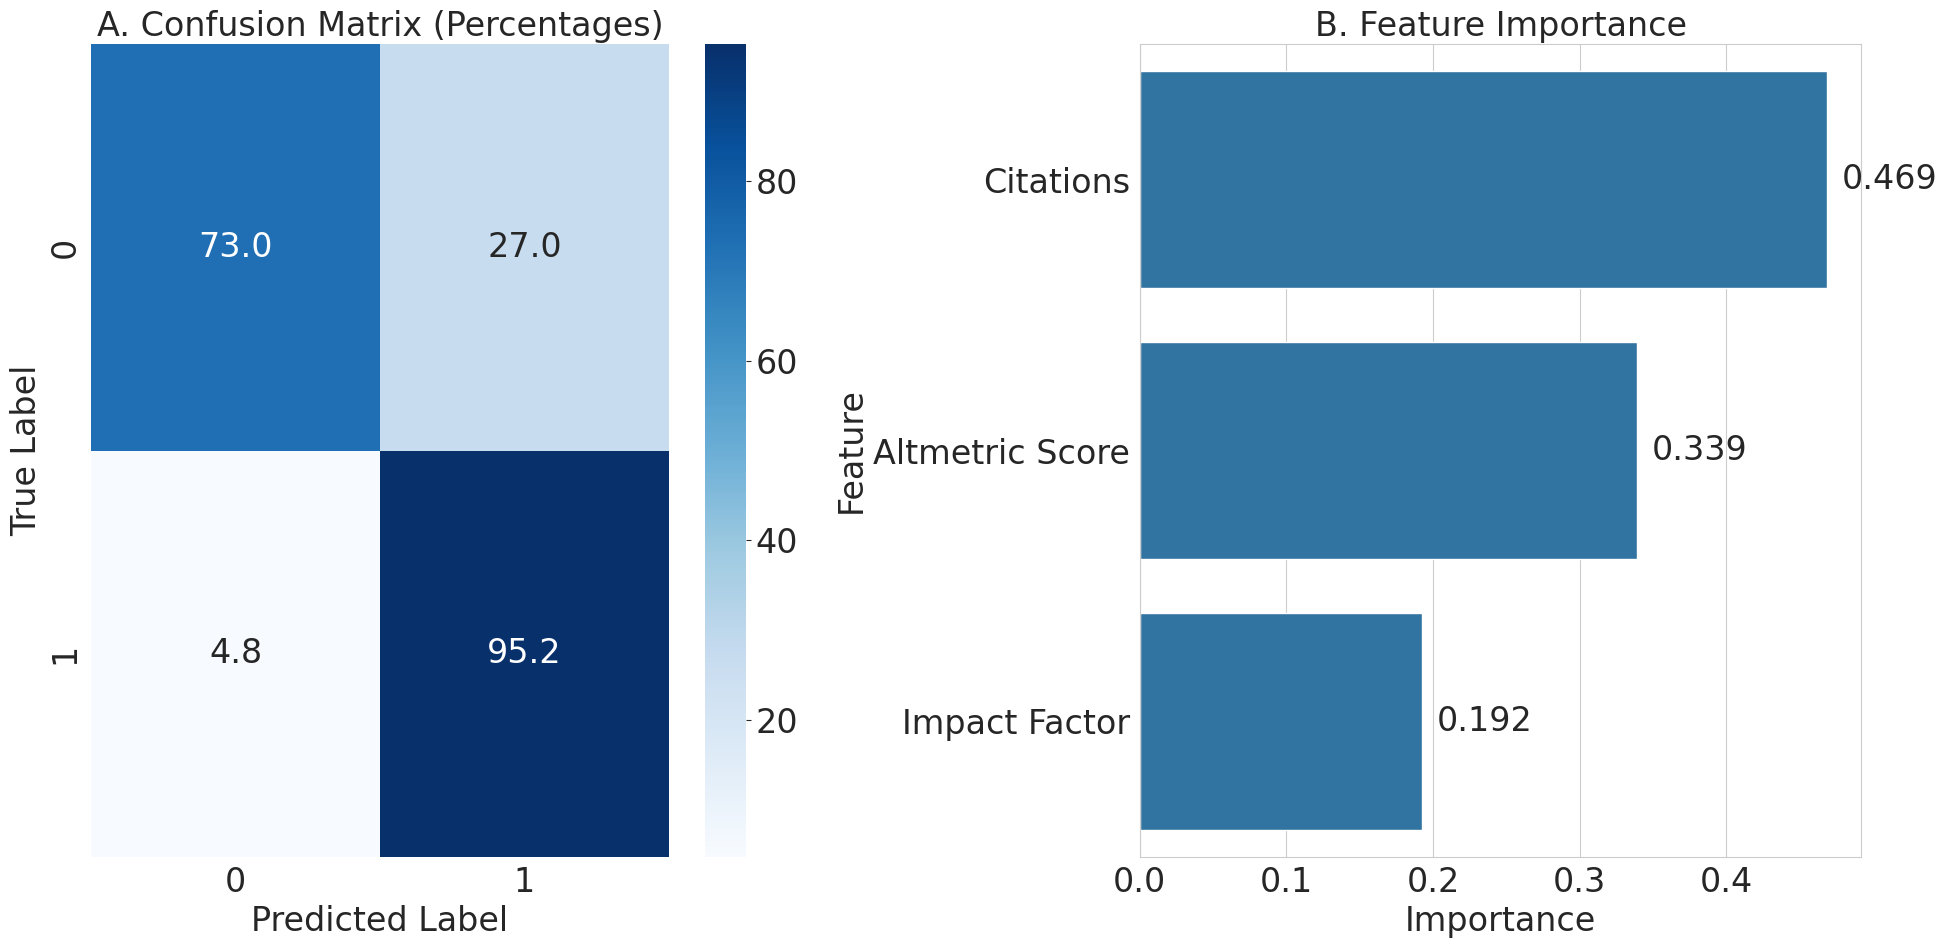

IndexError: index 1 is out of bounds for axis 0 with size 1

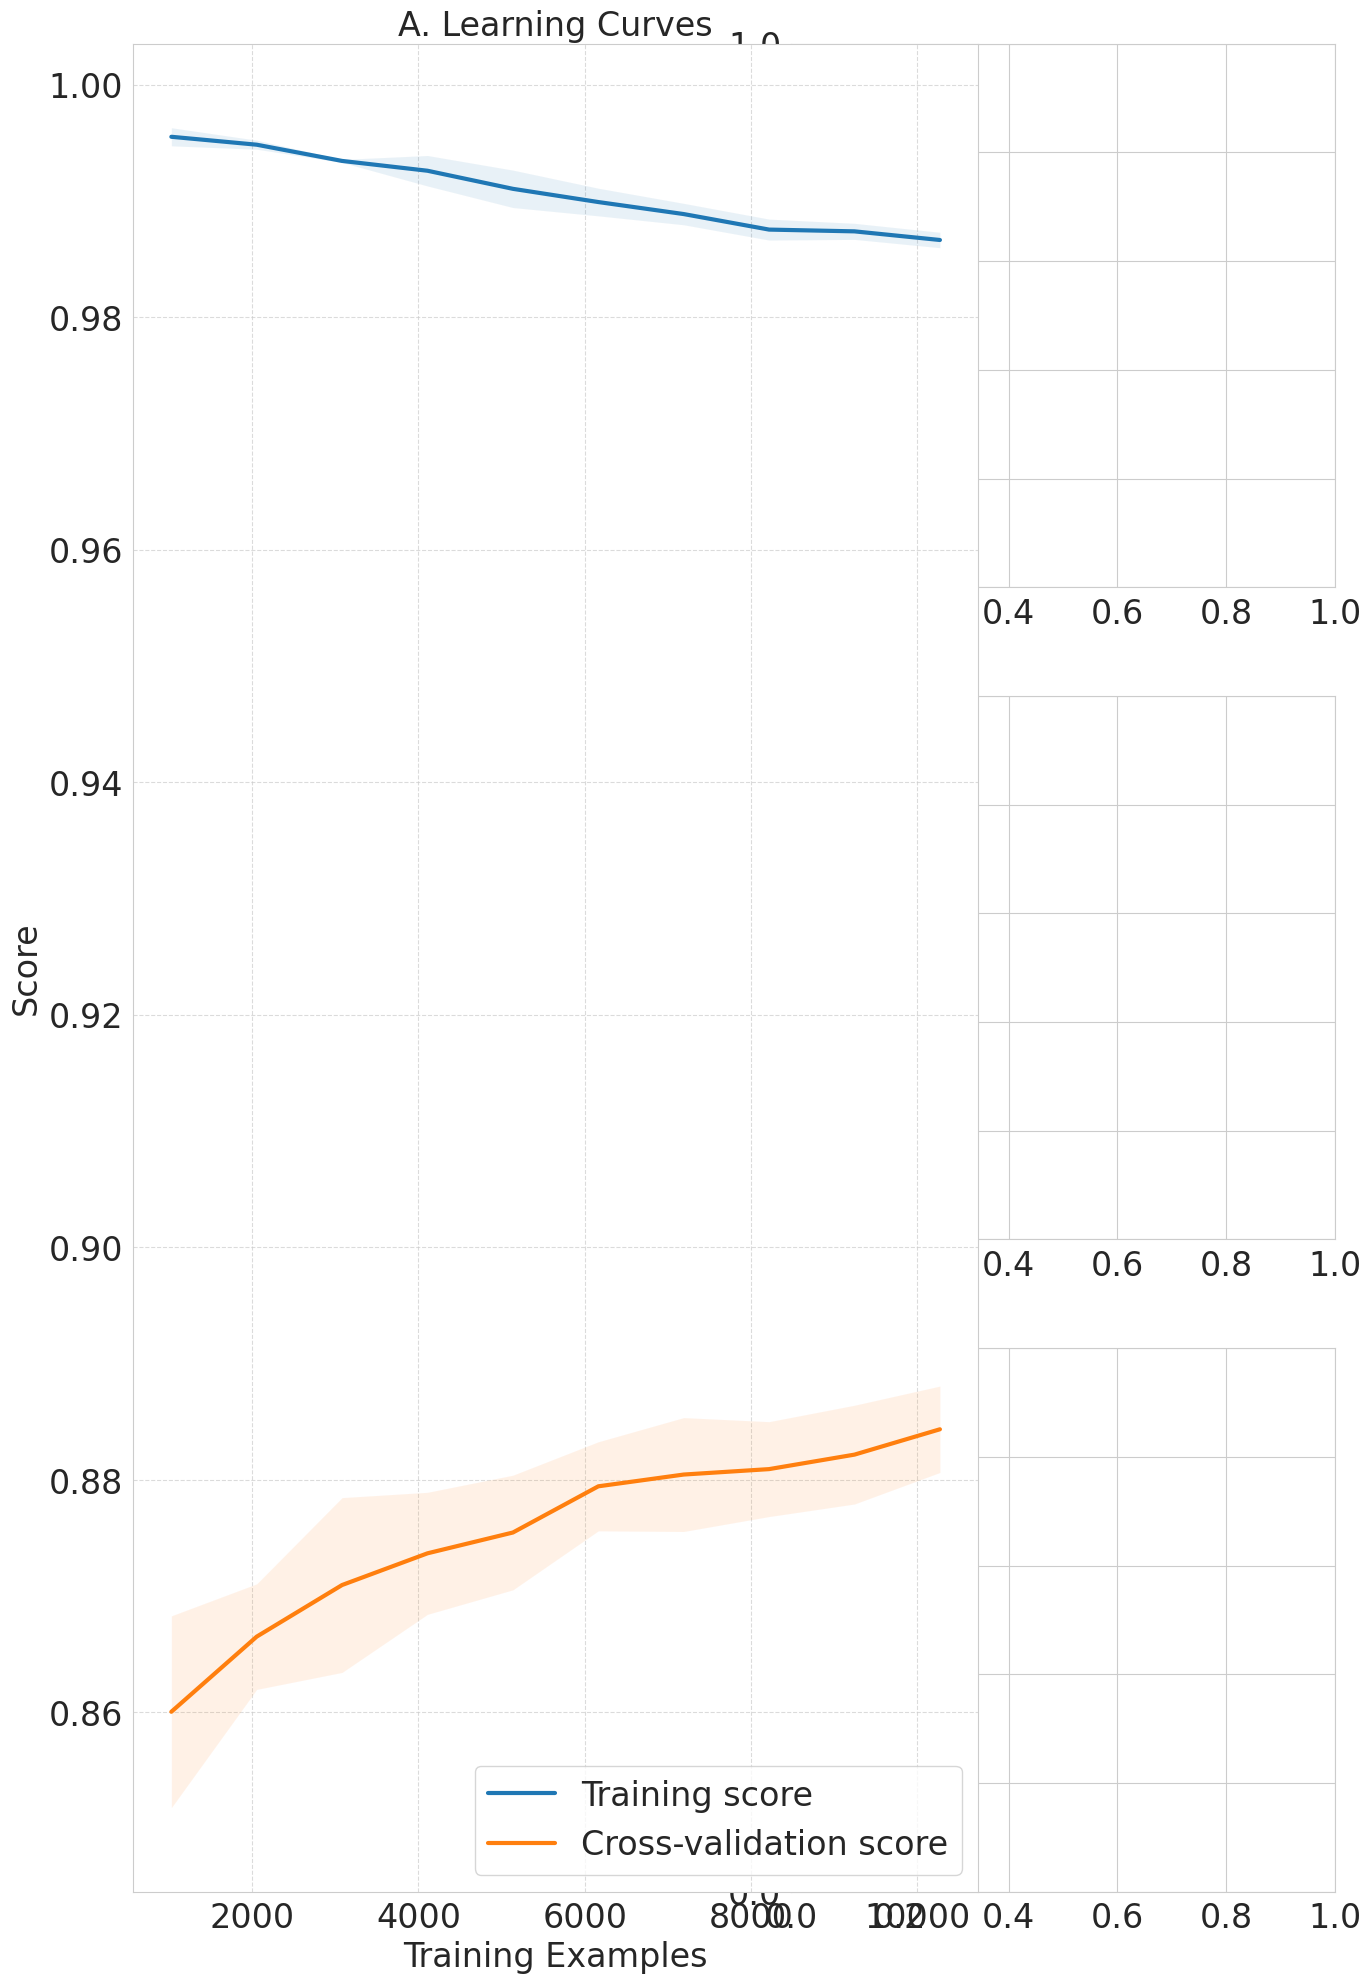

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set consistent font sizes to 24 for all elements
plt.rcParams.update({
    'font.size': 24,
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 24,
    'figure.titlesize': 24
})

# Set a consistent style
sns.set_style("whitegrid")

# Read and prepare the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/retract_class.csv')

# Clean Impact Factor
df['Impact Factor'] = df['Impact Factor'].replace('<0.1', '0')
df['Impact Factor'] = pd.to_numeric(df['Impact Factor'])

# Prepare features and target
X = df[['Cited', 'altmetric_score', 'Impact Factor']]
y = df['retracted']
y = (y == 'yes').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Get predictions and probabilities
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# 1. Basic Performance Metrics
print("1. Basic Performance Metrics")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# COMBINED FIGURE 1: Confusion Matrix and Feature Importance
fig1 = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig1)

# A. Confusion Matrix with Percentages
ax1 = fig1.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax1, annot_kws={"size": 24})
ax1.set_title('A. Confusion Matrix (Percentages)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# B. Feature Importance Analysis
importance = pd.DataFrame({
    'Feature': ['Citations', 'Altmetric Score', 'Impact Factor'],
    'Importance': rf_model.feature_importances_
})
importance = importance.sort_values('Importance', ascending=False)

ax2 = fig1.add_subplot(gs[0, 1])
sns.barplot(x='Importance', y='Feature', data=importance, ax=ax2)
ax2.set_title('B. Feature Importance')
# Add feature importance values with larger font
for i, v in enumerate(importance['Importance']):
    ax2.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=24)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/wos_data/combined_cm_feature_importance.png', dpi=300)
plt.show()  # This will display the figure in the output
plt.close(fig1)

# COMBINED FIGURE 2: Learning Curves, Precision-Recall Curve, and ROC Curve
fig2 = plt.figure(figsize=(24, 24))

# Use subplot2grid to create three square plots
ax3 = plt.subplot2grid((3, 1), (0, 0), aspect='equal')
ax4 = plt.subplot2grid((3, 1), (1, 0), aspect='equal')
ax5 = plt.subplot2grid((3, 1), (2, 0), aspect='equal')

# A. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

ax3 = fig2.add_subplot(gs[0, 0])
ax3.plot(train_sizes, train_mean, label='Training score', linewidth=3)
ax3.plot(train_sizes, test_mean, label='Cross-validation score', linewidth=3)
ax3.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax3.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
ax3.set_xlabel('Training Examples')
ax3.set_ylabel('Score')
ax3.set_title('A. Learning Curves')
ax3.legend(loc='best')
ax3.grid(True, linestyle='--', alpha=0.7)

# B. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

ax4 = fig2.add_subplot(gs[1, 0])
ax4.plot(recall, precision, color='blue', lw=3,
        label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('B. Precision-Recall Curve')
ax4.legend(loc="lower left")
ax4.grid(True, linestyle='--', alpha=0.7)

# C. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax5 = fig2.add_subplot(gs[2, 0])
ax5.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax5.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('C. Receiver Operating Characteristic (ROC) Curve')
ax5.legend(loc="lower right")
ax5.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Add space between subplots to maintain square aspect
plt.savefig('/content/drive/MyDrive/wos_data/combined_curves.png', dpi=300)
plt.show()  # This will display the figure in the output
plt.close(fig2)

# Error Analysis
error_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred,
    'Probability': y_pred_proba,
    'Citations': X_test['Cited'],
    'Altmetric_Score': X_test['altmetric_score'],
    'Impact_Factor': X_test['Impact Factor']
})

# Find misclassified samples
false_positives = error_df[(error_df['True_Label'] == 0) & (error_df['Predicted_Label'] == 1)]
false_negatives = error_df[(error_df['True_Label'] == 1) & (error_df['Predicted_Label'] == 0)]

print("\n7. Error Analysis")
print("-" * 50)
print("\nFalse Positive Analysis (Predicted retracted when actually not):")
print(false_positives[['Citations', 'Altmetric_Score', 'Impact_Factor', 'Probability']].describe())

print("\nFalse Negative Analysis (Predicted not retracted when actually retracted):")
print(false_negatives[['Citations', 'Altmetric_Score', 'Impact_Factor', 'Probability']].describe())

# Save detailed error analysis
error_analysis = pd.DataFrame({
    'Metric': ['False Positives', 'False Negatives', 'True Positives', 'True Negatives'],
    'Count': [
        len(false_positives),
        len(false_negatives),
        len(error_df[(error_df['True_Label'] == 1) & (error_df['Predicted_Label'] == 1)]),
        len(error_df[(error_df['True_Label'] == 0) & (error_df['Predicted_Label'] == 0)])
    ]
})
error_analysis.to_csv('/content/drive/MyDrive/wos_data/error_analysis.csv', index=False)